# Exploring dimensionless numbers and Neural Network Regression
Author: Payam Mousavi  
Last updated: December 26, 2020

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
matplotlib.rcParams.update({'font.size': 22})
eps = 1e-12

In [2]:
def CD_calc(Re=None, U=None, D=None, rho=None, mu=None):
    """
    Calculates the the Drag coefficient (CD) and the corresponding Drag force (FD), using the empirical equation found in the
    reference: https://pages.mtu.edu/~fmorriso/DataCorrelationForSphereDrag2016.pdf
    
    Use SI units
    
    """
    if Re is None:
        Re = rho*U*D/mu
    
    # Check to make sure Re value provided is consistent:
    if Re is not None:
        if U is not None:
            assert Re==rho*U*D/mu, "Provided Re is inconsistent with U, D, rho, and mu provided!"
            
    CD = (24/Re) \
    + ((2.6*(Re/5.)) / (1+(Re/5.)**1.52)) \
    + ((0.411*(Re/2.63e5)**-7.94) / (1 + (Re/2.63e5)**-8.)) \
    + ((0.25*(Re/1e6)) / (1 + (Re/1e6)))

    # Calculate FD if U and D and rho are given:
    if U is not None:
        FD = CD * (rho*np.pi/8) * (U**2) * (D**2)
    else:
        FD = None
        
    return CD, FD

def run_experiment(velocities, diameter, density, viscosity):
    """
    Runs the experiment by iterating over the velocity vector us and returning the drag coefficient CD and Drag force FD
    
    """
    FDs = np.zeros(len(velocities))
    CDs = np.zeros(len(velocities))
    for ind, u in enumerate(velocities):
        CDs[ind], FDs[ind] = CD_calc(Re=None, U=u, D=diameter, rho=density, mu=viscosity)
        
    return CDs, FDs

In [3]:
# # Test CD Forward Solver:
# Re_vec = np.geomspace(0.001, 1e7, 200)
# CD_vec = []
# for r in Re_vec:
#     CD_vec.append(CD_calc(Re=r))

In [55]:
def plot_CD(Re, CD, marker):
    plt.figure(figsize=(6,6))
    plt.loglog(Re, CD, marker)
    plt.ylim(1e-2, 1e4)
    plt.xlim(1e-2, 1e7)
    plt.xlabel('$Re$')
    plt.ylabel('$C_D$')
    return True

def plot_FD(Re, FD, marker):
    fig = plt.figure(figsize=(6,6))    
    plt.loglog(Re, FD, marker)
    plt.ylim(eps, 1e4)
    plt.xlim(1e-2, 1e7)
    plt.xlabel('$Re$')
    plt.ylabel('$F_D$')
    return True

def make_plots(Re, CD, FD, experiment_id, fig=None, ax1=None, ax2=None):
#     fig = plt.figure(figsize=(6,6))
    if ax1 is None:
        fig, (ax1, ax2) = plt.subplots(1, 2)
    
    ax1.loglog(Re, CD, 'b-o')
    ax1.set_xlabel('$Re$')
    ax1.set_ylabel('$C_D$')


    ax2.loglog(Re, FD, 'r-o')
    ax2.set_xlabel('$Re$')
    ax2.set_ylabel('$F_D$')

    plt.subplots_adjust(right=3)
    fig.suptitle(experiment_id)
    
    return fig, ax1, ax2

In [43]:
# # Plot results from the forward solver:
# plt.figure(figsize=(6,6))
# plt.loglog(Re_vec, CD_vec, 'b-o')
# plt.ylim(1e-2, 1e4)
# plt.xlim(1e-2, 1e7)
# plt.xlabel('$Re$')
# plt.ylabel('$C_D$')

There are other ways to non-dimensionalize the $F_D$:  
$\Pi_1$ := $C_D$ = $\frac{F_D}{\rho.U^2.D^2}$ 

$\Pi_2$ = $\frac{F_D}{\mu.U.D}$  

$\Pi_3$ = $\frac{\rho.F_D}{\mu^2}$  

$\Pi_4$ = $\frac{F_D}{\mu.U}$

Assuming we can generate $F_D$ (i.e., experimentally), we want to explore the following:
* Plot the other $\Pi$ groups as a function for $Re$ to see how they look  
* If we were to randomly sample the main physical parameters (i.e., $\rho$, $U$, $\mu$, $D$), how efficiently and how well can we estimate $F_D$? The ground-truth is taken to be the experimental $C_D$ values fitted above.
* If instead, of the main physical parameters we use $Re$, $U$, $D$, and $\rho$ can we estimate $F_D$ more efficiently or better?
* How do I best visualize $F_D$ vs. $Re$? We expect the curve not to be as nice?
* To start, let's keep $\rho$ and $\mu$ constant? Let's try water....

For all estimates, we will try first to use a deep fully connected network with some non-linearity.

Insight?: The non-dimensionalization helps with more efficient sampleing of the independent variable space? Uniformly sampling $Re$ more efficiently covers the space. 

## Experiments:
Generating some 'experimental' data and comparing different $\Pi$ groups

### Material parameters:

In [6]:
# Let's take water as an example: rho = 1000Kg/m^3, mu = 0.001 Ns/M^2
# c_sound (Cs) in water ~ 1481 m/s, Cs(Acetone) = ~1100 m/s - We need to make sure the velocity is < 0.3*Cs
N = 200 # Number of samples
Cs = 1481 # m/s
u_max = 0.2 * Cs # Picked 0.2 to make sure the condition is not violated for acetone

mu_water = 0.001 # [SI]
rho_water = 1000 # [SI]

mu_acetone = 0.000316 # Acetone [SI]
rho_acetone = 784.5 # Acetone [SI]

# Sphere diameters:
D_I = 0.05 # Diameter of sphere
D_II = 0.1
D_III = 0.5

### Setting up the 'Experiments':

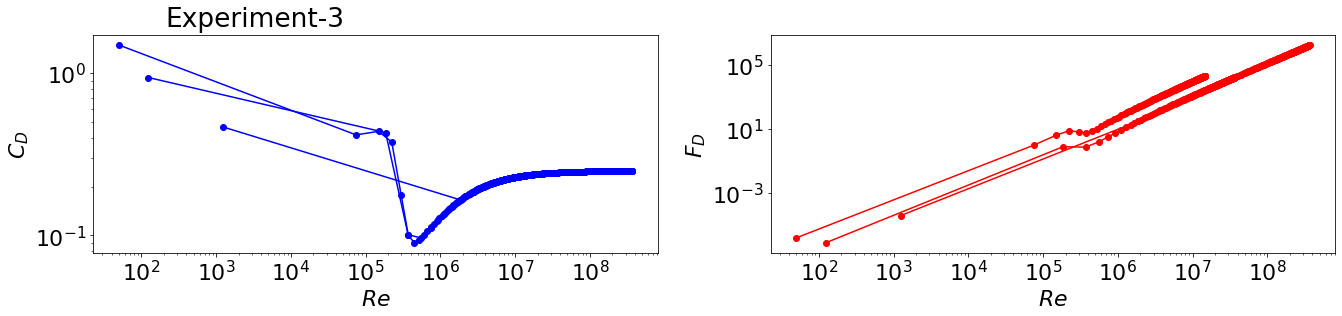

In [61]:
# Let's keep the velocities the same for now:
us = np.linspace(0.001, u_max, N)

# Experiment #1:
mu_1 = mu_water
rho_1 = rho_water
D_1 = D_I
REs_1 = [rho_1*uu*D_1/mu_1 for uu in us]
CDs_1, FDs_1 = run_experiment(velocities=us, diameter=D_1, density=rho_1, viscosity=mu_1)
# plot_CD(Re = REs_1, CD = CDs_1, marker='b-o')
# plot_FD(Re = REs_1, FD = FDs_1, marker='r-s')
fig, ax1, ax2 = make_plots(Re=REs_1, CD=CDs_1, FD=FDs_1, experiment_id='Experiment-1')

# Experiment #2:
mu_2 = mu_acetone
rho_2 = rho_acetone
D_2 = D_I
REs_2 = [rho_2*uu*D_2/mu_2 for uu in us]
CDs_2, FDs_2 = run_experiment(velocities=us, diameter=D_2, density=rho_2, viscosity=mu_2)
fig, ax1, ax2 = make_plots(Re=REs_2, CD=CDs_2, FD=FDs_2, experiment_id='Experiment-2', fig=fig, ax1=ax1, ax2=ax2)

# Experiment #3:
mu_3 = mu_acetone
rho_3 = rho_acetone
D_3 = D_III
REs_3 = [rho_3*uu*D_3/mu_3 for uu in us]
CDs_3, FDs_3 = run_experiment(velocities=us, diameter=D_3, density=rho_3, viscosity=mu_3)
fig, ax1, ax2 = make_plots(Re=REs_3, CD=CDs_3, FD=FDs_3, experiment_id='Experiment-3', fig=fig, ax1=ax1, ax2=ax2)